In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
results_file = "/data/jane/math_gender/conversion_test/language_conversion_results/language_conversion_results_20251224_073823.json" # most recent with qwen, gpt, llama. we actually have a newer one that took weeks to run that i just saw populated!
output_dir = "analysis_output"

def load_results(results_file):
    """Load the conversion results JSON file."""
    with open(results_file, 'r') as f:
        return json.load(f)

# Load data
print(f"Loading results from: {results_file}")
results = load_results(results_file)

# Convert to DataFrame
df = pd.DataFrame(results)

# Filter out errors
df_clean = df[~df['is_error']].copy()

print(f"\nTotal results: {len(df)}")
print(f"Valid results (no errors): {len(df_clean)}")
print(f"Error rate: {(len(df) - len(df_clean)) / len(df) * 100:.2f}%")
print(f"\nModels: {df_clean['model'].unique().tolist()}")
print(f"Languages: {df_clean['language'].unique().tolist()}")

df = df_clean 

Loading results from: /data/jane/math_gender/conversion_test/language_conversion_results/language_conversion_results_20251224_073823.json

Total results: 146426
Valid results (no errors): 145636
Error rate: 0.54%

Models: ['gpt-4o', 'qwen-coder', 'llama-4']
Languages: ['english', 'japanese', 'context_free']


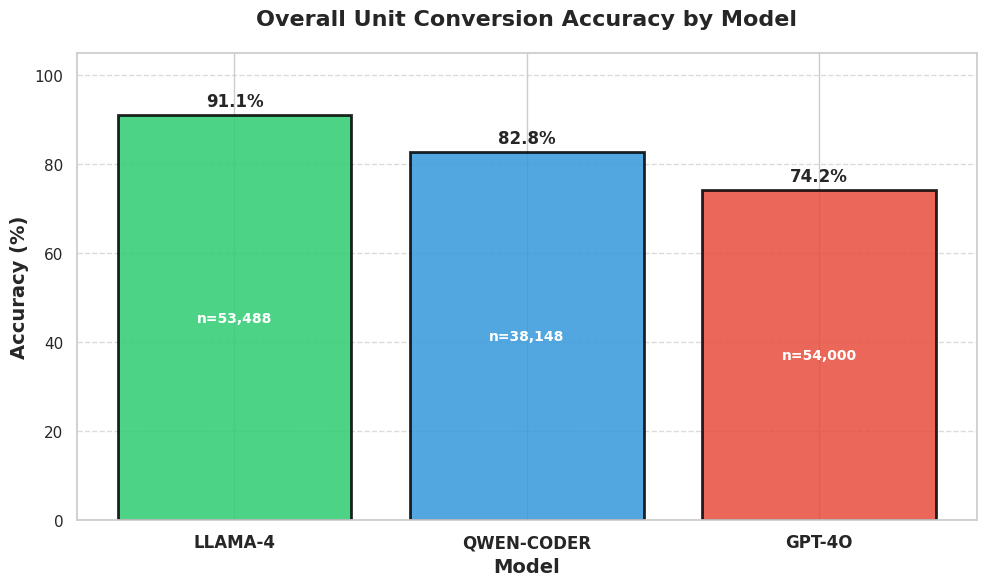


Overall Accuracy:
     model  correct  total  accuracy
   llama-4    48712  53488 91.070894
qwen-coder    31577  38148 82.774982
    gpt-4o    40073  54000 74.209259


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate accuracy by model
accuracy_data = df.groupby('model')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
accuracy_data.columns = ['model', 'correct', 'total', 'accuracy']
accuracy_data['accuracy'] = accuracy_data['accuracy'] * 100
accuracy_data = accuracy_data.sort_values('accuracy', ascending=False)

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(range(len(accuracy_data)), accuracy_data['accuracy'],
              color=colors, edgecolor='black', linewidth=2, alpha=0.85)

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Overall Unit Conversion Accuracy by Model', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(len(accuracy_data)))
ax.set_xticklabels([m.upper() for m in accuracy_data['model']], fontsize=12, fontweight='bold')
ax.set_ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add value labels
for i, (bar, row) in enumerate(zip(bars, accuracy_data.itertuples())):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           f'{height:.1f}%', ha='center', va='bottom', 
           fontsize=12, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
           f'n={int(row.total):,}', ha='center', va='center',
           fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/overall_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nOverall Accuracy:")
print(accuracy_data.to_string(index=False))


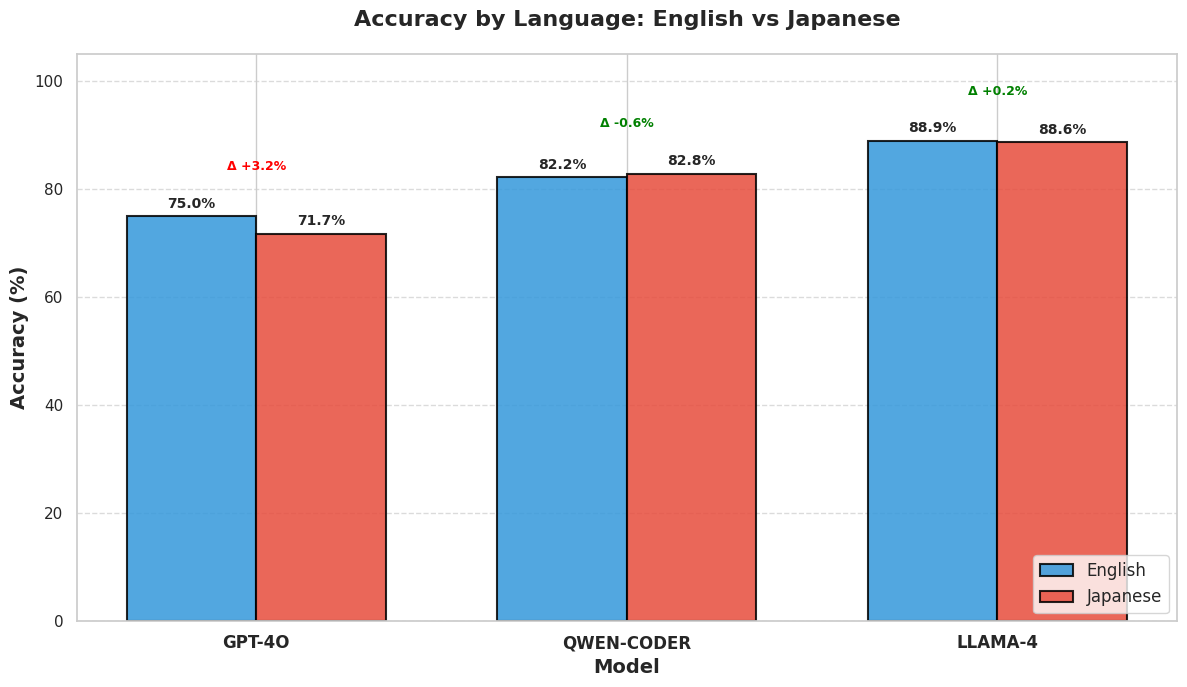

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

# Get languages (excluding context_free)
languages = df[df['language'] != 'context_free']['language'].unique()
models = df['model'].unique()

# Calculate accuracy by model and language
lang_accuracy = df[df['language'] != 'context_free'].groupby(['model', 'language'])['is_correct'].mean() * 100

x = np.arange(len(models))
width = 0.35

# Extract data for each language
lang1_data = []
lang2_data = []

for model in models:
    try:
        lang1_acc = lang_accuracy[model, languages[0]]
    except:
        lang1_acc = 0
    try:
        lang2_acc = lang_accuracy[model, languages[1]]
    except:
        lang2_acc = 0
    
    lang1_data.append(lang1_acc)
    lang2_data.append(lang2_acc)

bars1 = ax.bar(x - width/2, lang1_data, width, 
               label=languages[0].capitalize(), color='#3498db',
               edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, lang2_data, width,
               label=languages[1].capitalize(), color='#e74c3c',
               edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title(f'Accuracy by Language: {languages[0].capitalize()} vs {languages[1].capitalize()}',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models], fontsize=12, fontweight='bold')
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='lower right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add value labels and differences
for i in range(len(models)):
    # Lang 1
    ax.text(bars1[i].get_x() + bars1[i].get_width()/2., lang1_data[i] + 1,
           f'{lang1_data[i]:.1f}%', ha='center', va='bottom',
           fontsize=10, fontweight='bold')
    # Lang 2
    ax.text(bars2[i].get_x() + bars2[i].get_width()/2., lang2_data[i] + 1,
           f'{lang2_data[i]:.1f}%', ha='center', va='bottom',
           fontsize=10, fontweight='bold')
    # Difference
    diff = lang1_data[i] - lang2_data[i]
    y_pos = max(lang1_data[i], lang2_data[i]) + 8
    color = 'green' if abs(diff) < 1 else 'red'
    ax.text(i, y_pos, f'Δ {diff:+.1f}%',
           ha='center', va='bottom', fontsize=9,
           fontweight='bold', color=color)

plt.tight_layout()
plt.savefig(f"{output_dir}/language_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

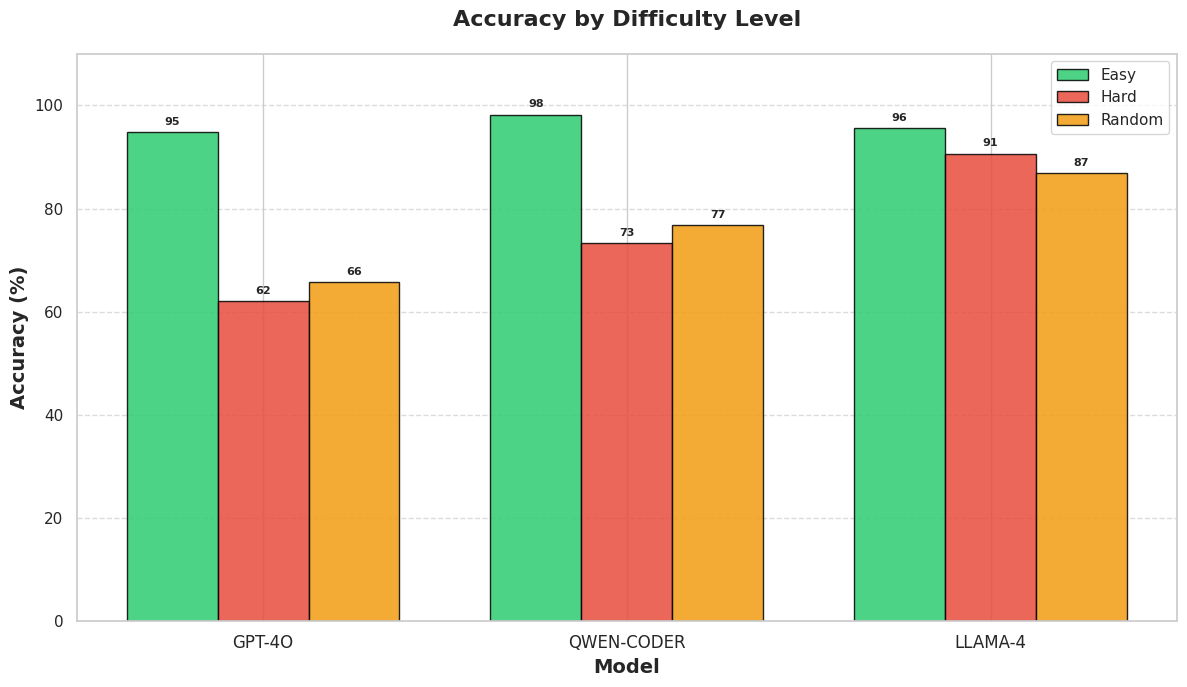

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

models = df['model'].unique()
difficulties = ['easy', 'hard', 'random']

x = np.arange(len(models))
width = 0.25

colors_diff = {'easy': '#2ecc71', 'hard': '#e74c3c', 'random': '#f39c12'}

for i, difficulty in enumerate(difficulties):
    difficulty_data = []
    for model in models:
        acc = df[(df['model'] == model) & (df['difficulty'] == difficulty)]['is_correct'].mean() * 100
        difficulty_data.append(acc)
    
    offset = width * (i - 1)
    bars = ax.bar(x + offset, difficulty_data, width,
                 label=difficulty.capitalize(), color=colors_diff[difficulty],
                 edgecolor='black', linewidth=1, alpha=0.85)
    
    # Add value labels
    for j, (bar, acc) in enumerate(zip(bars, difficulty_data)):
        if acc > 0:
            ax.text(bar.get_x() + bar.get_width()/2., acc + 1,
                   f'{acc:.0f}', ha='center', va='bottom',
                   fontsize=8, fontweight='bold')

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Accuracy by Difficulty Level', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in models], fontsize=12)
ax.set_ylim(0, 110)
ax.legend(fontsize=11, loc='upper right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(f"{output_dir}/difficulty_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

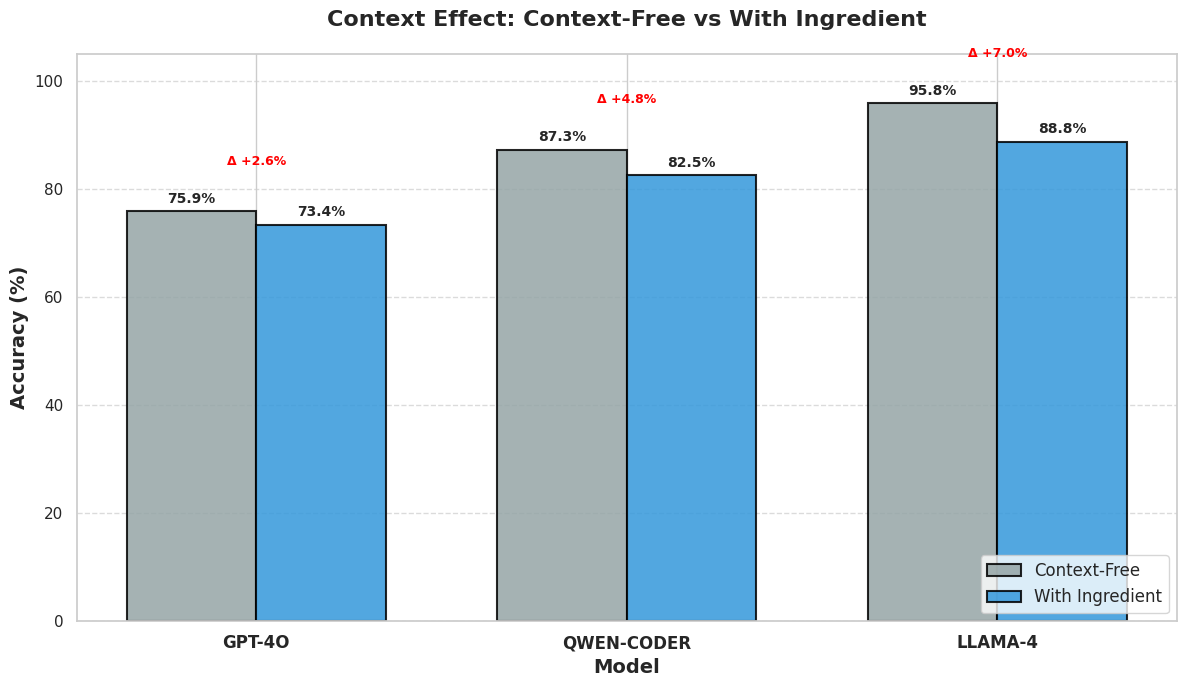

In [ ]:
if 'context_free' in df['language'].values:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    models = df['model'].unique()
    
    context_free_data = []
    with_context_data = []
    
    for model in models:
        cf_acc = df[(df['model'] == model) & (df['language'] == 'context_free')]['is_correct'].mean() * 100
        wc_acc = df[(df['model'] == model) & (df['language'] != 'context_free')]['is_correct'].mean() * 100
        
        context_free_data.append(cf_acc)
        with_context_data.append(wc_acc)
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, context_free_data, width,
                   label='Context-Free', color='#95a5a6',
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    bars2 = ax.bar(x + width/2, with_context_data, width,
                   label='With Ingredient', color='#3498db',
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Context Effect: Context-Free vs With Ingredient',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 105)
    ax.legend(fontsize=12, loc='lower right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels and effect size
    for i in range(len(models)):
        ax.text(bars1[i].get_x() + bars1[i].get_width()/2., context_free_data[i] + 1,
               f'{context_free_data[i]:.1f}%', ha='center', va='bottom',
               fontsize=10, fontweight='bold')
        ax.text(bars2[i].get_x() + bars2[i].get_width()/2., with_context_data[i] + 1,
               f'{with_context_data[i]:.1f}%', ha='center', va='bottom',
               fontsize=10, fontweight='bold')
        
        effect = context_free_data[i] - with_context_data[i]
        y_pos = max(context_free_data[i], with_context_data[i]) + 8
        color = 'green' if abs(effect) < 0.5 else 'red'
        ax.text(i, y_pos, f'Δ {effect:+.1f}%',
               ha='center', va='bottom', fontsize=9,
               fontweight='bold', color=color)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/context_effect.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No context-free data found")

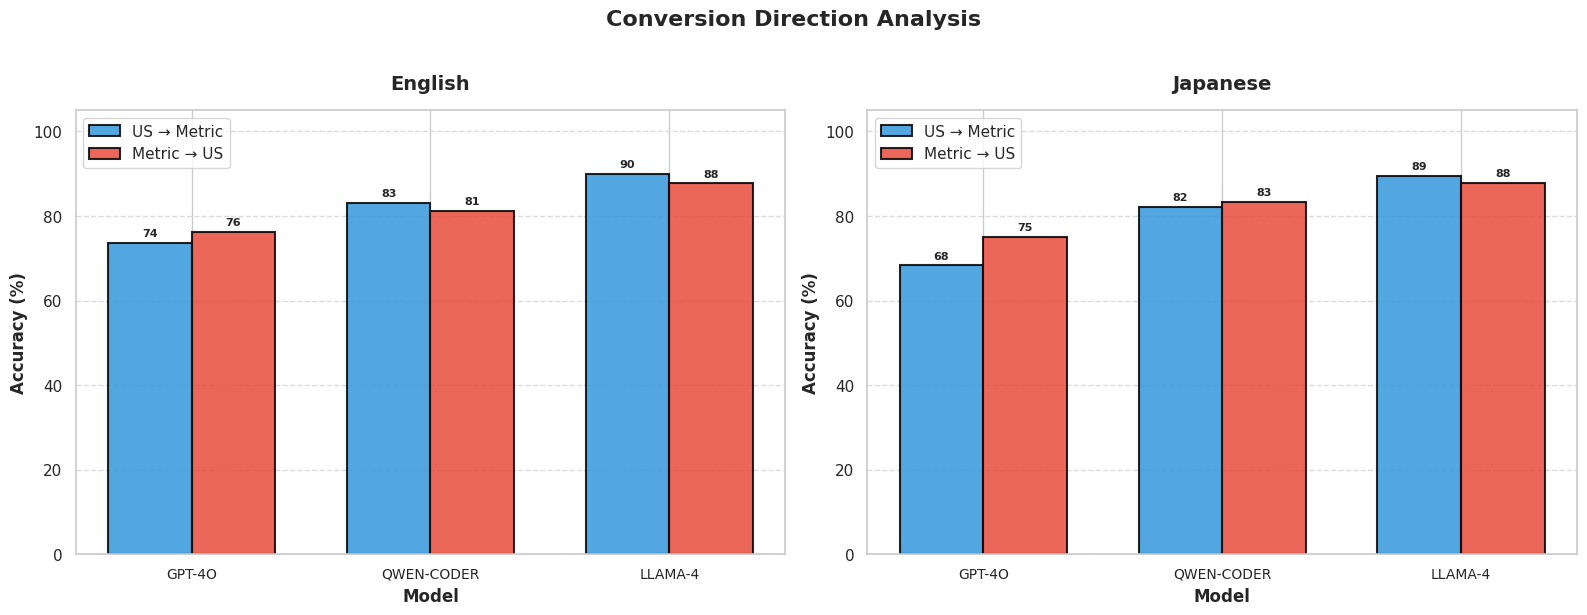

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = df['model'].unique()
languages = df[df['language'] != 'context_free']['language'].unique()

for idx, lang in enumerate(languages):
    ax = axes[idx]
    lang_data = df[df['language'] == lang]
    
    us_to_metric = []
    metric_to_us = []
    
    for model in models:
        us_acc = lang_data[(lang_data['model'] == model) & 
                          (lang_data['conversion_type'] == 'us_to_metric')]['is_correct'].mean() * 100
        metric_acc = lang_data[(lang_data['model'] == model) & 
                              (lang_data['conversion_type'] == 'metric_to_us')]['is_correct'].mean() * 100
        
        us_to_metric.append(us_acc)
        metric_to_us.append(metric_acc)
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, us_to_metric, width,
                  label='US → Metric', color='#3498db',
                  edgecolor='black', linewidth=1.5, alpha=0.85)
    bars2 = ax.bar(x + width/2, metric_to_us, width,
                  label='Metric → US', color='#e74c3c',
                  edgecolor='black', linewidth=1.5, alpha=0.85)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'{lang.capitalize()}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=10)
    ax.set_ylim(0, 105)
    ax.legend(fontsize=11)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels
    for i in range(len(models)):
        if us_to_metric[i] > 0:
            ax.text(bars1[i].get_x() + bars1[i].get_width()/2., us_to_metric[i] + 1,
                   f'{us_to_metric[i]:.0f}', ha='center', va='bottom',
                   fontsize=8, fontweight='bold')
        if metric_to_us[i] > 0:
            ax.text(bars2[i].get_x() + bars2[i].get_width()/2., metric_to_us[i] + 1,
                   f'{metric_to_us[i]:.0f}', ha='center', va='bottom',
                   fontsize=8, fontweight='bold')

plt.suptitle('Conversion Direction Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{output_dir}/conversion_direction.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# Overall by model
print("\n1. Overall Accuracy by Model:")
overall = df.groupby('model')['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
overall.columns = ['Model', 'Correct', 'Total', 'Accuracy']
overall['Accuracy'] = overall['Accuracy'] * 100
overall = overall.sort_values('Accuracy', ascending=False)
print(overall.to_string(index=False))

# By language
print("\n2. Accuracy by Model and Language:")
lang_stats = df[df['language'] != 'context_free'].groupby(['model', 'language'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
lang_stats.columns = ['Model', 'Language', 'Correct', 'Total', 'Accuracy']
lang_stats['Accuracy'] = lang_stats['Accuracy'] * 100
print(lang_stats.to_string(index=False))

# By difficulty
print("\n3. Accuracy by Difficulty:")
diff_stats = df.groupby(['model', 'difficulty'])['is_correct'].agg(['sum', 'count', 'mean']).reset_index()
diff_stats.columns = ['Model', 'Difficulty', 'Correct', 'Total', 'Accuracy']
diff_stats['Accuracy'] = diff_stats['Accuracy'] * 100
print(diff_stats.to_string(index=False))

# Language bias
print("\n4. Language Bias Analysis:")
languages = df[df['language'] != 'context_free']['language'].unique()
if len(languages) >= 2:
    for model in df['model'].unique():
        model_data = df[(df['model'] == model) & (df['language'] != 'context_free')]
        lang1_acc = model_data[model_data['language'] == languages[0]]['is_correct'].mean() * 100
        lang2_acc = model_data[model_data['language'] == languages[1]]['is_correct'].mean() * 100
        diff = lang1_acc - lang2_acc
        
        print(f"\n{model.upper()}:")
        print(f"  {languages[0].capitalize()}: {lang1_acc:.2f}%")
        print(f"  {languages[1].capitalize()}: {lang2_acc:.2f}%")
        print(f"  Difference: {diff:+.2f}% ", end="")
        if abs(diff) < 1:
            print("(NEUTRAL)")
        elif diff > 0:
            print(f"(favors {languages[0]})")
        else:
            print(f"(favors {languages[1]})")

print("="*80)


STATISTICAL SUMMARY

1. Overall Accuracy by Model:
     Model  Correct  Total  Accuracy
   llama-4    48712  53488 91.070894
qwen-coder    31577  38148 82.774982
    gpt-4o    40073  54000 74.209259

2. Accuracy by Model and Language:
     Model Language  Correct  Total  Accuracy
    gpt-4o  english    13496  18000 74.977778
    gpt-4o japanese    12912  18000 71.733333
   llama-4  english    15999  17999 88.888272
   llama-4 japanese    15956  18000 88.644444
qwen-coder  english    14794  17997 82.202589
qwen-coder japanese    14903  17997 82.808246

3. Accuracy by Difficulty:
     Model Difficulty  Correct  Total  Accuracy
    gpt-4o       easy    17066  18000 94.811111
    gpt-4o       hard    11182  18000 62.122222
    gpt-4o     random    11825  18000 65.694444
   llama-4       easy    17066  17850 95.607843
   llama-4       hard    16178  17848 90.643209
   llama-4     random    15468  17790 86.947723
qwen-coder       easy    12502  12728 98.224387
qwen-coder       hard     9317

In [ ]:
# # Save summary tables
# overall.to_csv(f"{output_dir}/summary_overall.csv", index=False)
# lang_stats.to_csv(f"{output_dir}/summary_by_language.csv", index=False)
# diff_stats.to_csv(f"{output_dir}/summary_by_difficulty.csv", index=False)
# df.to_csv(f"{output_dir}/cleaned_results.csv", index=False)

# print(f"\n✓ All outputs saved to {output_dir}/")
# print(f"  - Plots: 5 PNG files")
# print(f"  - Summary tables: 3 CSV files")
# print(f"  - Cleaned data: cleaned_results.csv")